# Preprocessing file names

In [ ]:
# Preprocessing file names for the dataset
import os

def rename_files_in_folder(folder_path, GEN):
    files = os.listdir(folder_path)
    files = [file for file in files if os.path.isfile(os.path.join(folder_path, file))]
    # files.sort()
    
    for index, file_name in enumerate(files):
        extension = os.path.splitext(file_name)[1]
        if GEN:
            new_file_name = f"gen{index + 1}{extension}"
        else:
            new_file_name = f"real{index + 1}{extension}"
        
        old_file_path = os.path.join(folder_path, file_name)
        new_file_path = os.path.join(folder_path, new_file_name)
        
        os.rename(old_file_path, new_file_path)

generated_images = "E:\\CS 512 Project\\Proj\\data_image_classification\\generated_images"
real_images = "E:\\CS 512 Project\\Proj\\data_image_classification\\real_images"

In [ ]:
rename_files_in_folder(generated_images, True)
rename_files_in_folder(real_images, False)

### Separate the test files from all the files

In [ ]:
import os
import shutil
from random import sample

# Define the source and destination directories
gen_files = 'E:\\CS 512 Project\\Proj\\data_image_classification\\generated_images'
test_gen = 'E:\\CS 512 Project\\Proj\\test_data_image_classification\\test_gen'
real_files = 'E:\\CS 512 Project\\Proj\\data_image_classification\\real_images'
test_real = 'E:\\CS 512 Project\\Proj\\test_data_image_classification\\test_real'

files = os.listdir(gen_files)
os.makedirs(test_gen, exist_ok=True)
selected_files = sample(files, 20)
for file_name in selected_files:
    shutil.move(os.path.join(gen_files, file_name), os.path.join(test_gen, file_name))
    print(f"Moved {file_name} from {gen_files} to {test_gen}")

files = os.listdir(real_files)
os.makedirs(test_real, exist_ok=True)
selected_files = sample(files, 20)
for file_name in selected_files:
    shutil.move(os.path.join(real_files, file_name), os.path.join(test_real, file_name))
    print(f"Moved {file_name} from {real_files} to {test_real}")


# Base classifier model

In [1]:
!pip install tensorflow matplotlib
!pip install scipy
!pip install -U scikit-learn
!pip install seaborn

In [1]:
import numpy as np

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = 'E:/CS 512 Project/Proj/data_image_classification'
train_dir_generated = os.path.join(base_dir, 'generated_images')
train_dir_real = os.path.join(base_dir, 'real_images')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),  # resize images to 150x150
    batch_size=32,
    class_mode='binary', 
    subset='training' 
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)



Found 1341 images belonging to 2 classes.
Found 334 images belonging to 2 classes.


In [4]:
train_generator.class_indices

{'generated_images': 0, 'real_images': 1, 'test_gen': 2, 'test_real': 3}

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])


c:\Users\Manan\anaconda3\envs\proj\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [4]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor the validation loss
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

In [5]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Function for learning rate decay
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))

# Define the callback
lr_scheduler = LearningRateScheduler(scheduler)

In [6]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [7]:
# Custom F1 score metric
def f1_score(precision, recall):
    return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))

In [8]:
history = model.fit(
    train_generator,
    steps_per_epoch=100, 
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/20


c:\Users\Manan\anaconda3\envs\proj\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 42/100 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.5653 - loss: 1.6006 - precision: 0.5926 - recall: 0.5856

c:\Users\Manan\anaconda3\envs\proj\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.6107 - loss: 1.3579 - precision: 0.6345 - recall: 0.6454 - val_accuracy: 0.7605 - val_loss: 0.7467 - val_precision: 0.7131 - val_recall: 0.9337 - learning_rate: 0.0010
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.7651 - loss: 0.6965 - precision: 0.7667 - recall: 0.8112 - val_accuracy: 0.8383 - val_loss: 0.5293 - val_precision: 0.8757 - val_recall: 0.8177 - learning_rate: 0.0010
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.8198 - loss: 0.5367 - precision: 0.8380 - recall: 0.8356 - val_accuracy: 0.8353 - val_loss: 0.4949 - val_precision: 0.8150 - val_recall: 0.9006 - learning_rate: 0.0010
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.8180 - loss: 0.5145 - precision: 0.8182 - recall: 0.8510 - val_accuracy: 0.8144 - val_loss: 0.4634 - val_precision: 0.8606 - val_recall: 0.7845 - learning_rate: 0.0010
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.8423

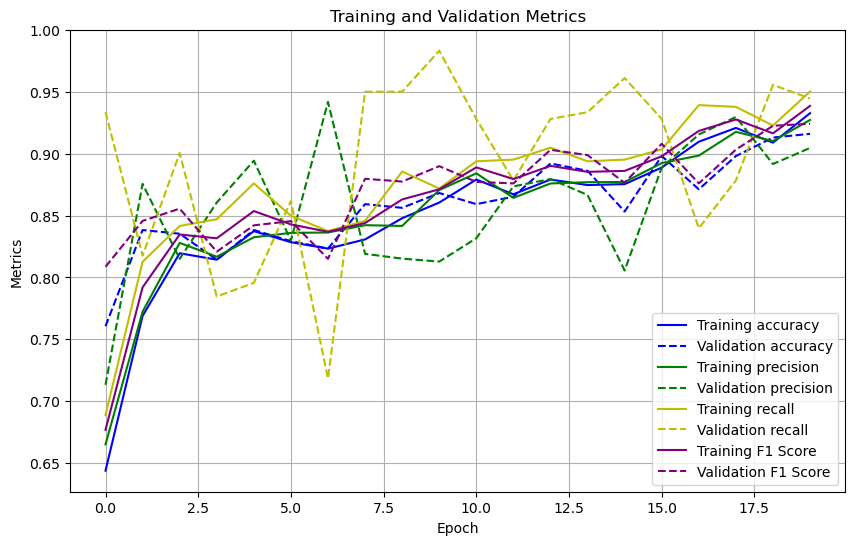

In [9]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt

acc = history.history['accuracy']
precision = history.history['precision']
recall = history.history['recall']
val_acc = history.history['val_accuracy']
val_precision = history.history['val_precision']
val_recall = history.history['val_recall']
epochs = range(len(acc))

f1_scores = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(precision, recall)]
val_f1_scores = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(val_precision, val_recall)]

plt.figure(figsize=(10, 6))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'b--', label='Validation accuracy')
plt.plot(epochs, history.history['precision'], 'g', label='Training precision')
plt.plot(epochs, history.history['val_precision'], 'g--', label='Validation precision')
plt.plot(epochs, history.history['recall'], 'y', label='Training recall')
plt.plot(epochs, history.history['val_recall'], 'y--', label='Validation recall')
plt.plot(epochs, f1_scores, 'purple', label='Training F1 Score')
plt.plot(epochs, val_f1_scores, 'purple', linestyle='dashed', label='Validation F1 Score')

plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


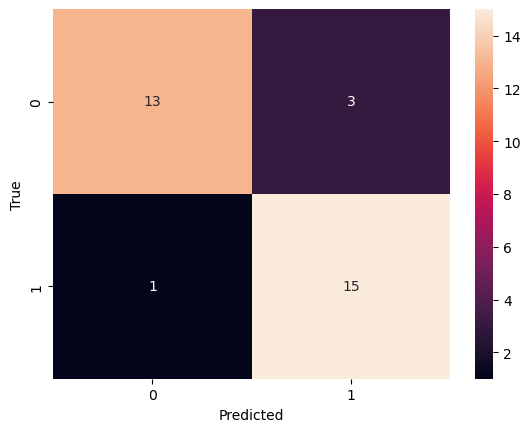

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate predictions for the validation set
val_images, val_labels = next(validation_generator)
val_predictions = model.predict(val_images)
val_predictions = np.round(val_predictions).astype(int)
val_labels = val_labels.astype(int)

# Compute the confusion matrix
cm = confusion_matrix(val_labels, val_predictions)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


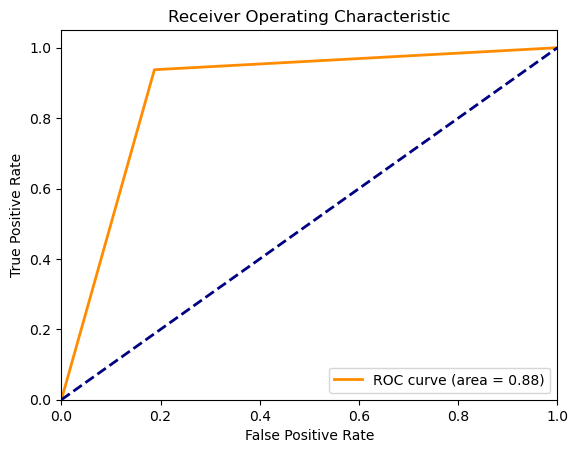

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(val_labels, val_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [14]:
model.save('E:\\CS 512 Project\\Proj\\classification.keras')

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,102,533 (217.83 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,068,356 (145.22 MB)

### Predictions

Found 40 images belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\Manan\AppData\Local\Temp\ipykernel_32140\2328305146.py:21: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
c:\Users\Manan\anaconda3\envs\proj\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


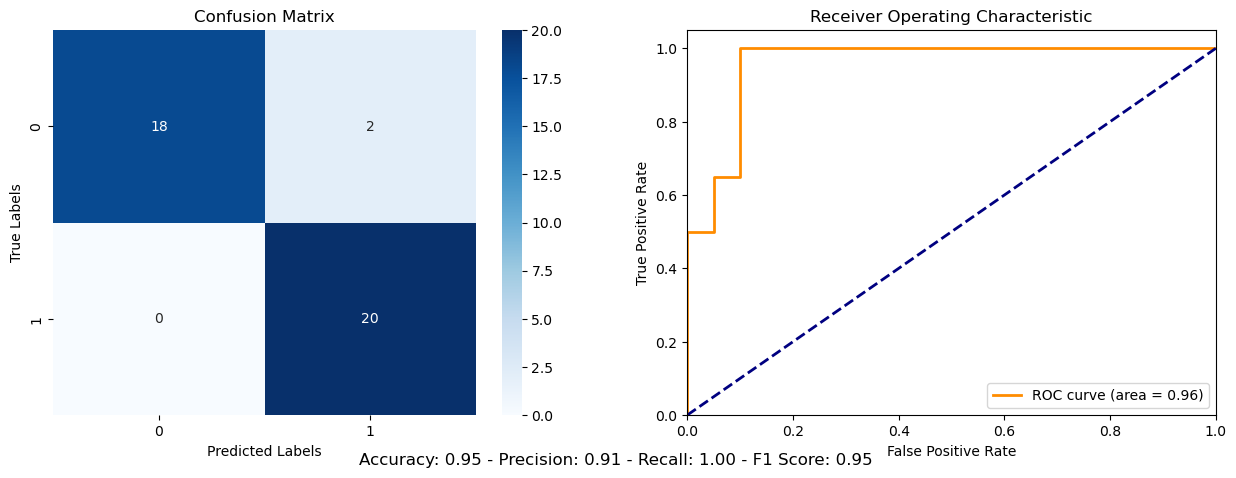

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = load_model('E:\\CS 512 Project\\Proj\\classification.keras')

# Prepare the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'E:/CS 512 Project/Proj/test_data_image_classification',
    target_size=(150, 150),
    batch_size=20,  # Assuming we are processing the whole set at once
    class_mode='binary',  # Change if your model uses a different class mode
    shuffle=False
)

# Make predictions on the test data
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)

# Get the true labels from the generator
true_labels = test_generator.classes

# Threshold the predictions to get binary results
predicted_labels = np.round(predictions).astype(int).reshape(-1)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', ax=ax[0], cmap='Blues')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')
ax[0].set_title('Confusion Matrix')

# ROC Curve (if needed)
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)
ax[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic')
ax[1].legend(loc="lower right")

# Metrics
plt.figtext(0.5, 0.01, f'Accuracy: {accuracy:.2f} - Precision: {precision:.2f} - Recall: {recall:.2f} - F1 Score: {f1:.2f}', ha='center', fontsize=12)
plt.show()
